Exploration of using Javier's dataset consisting of a power sweep for a 10-span system as an example of how to augment GPs with physical model priors. 
PLAN: 
* implement physical model-enhanced (homoscedastic) GP model for toy SNR(Pch) dataset 
* compare results with library, such as GPy
* compare results with own GP implementation with no physical model 
STEPS: 
1. Implement homoscedastic GP regression from stratch (object-orientated)
2. Implement a modified version in which physical models are used in fitting process and compare

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import GPy
import time

In [2]:
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]

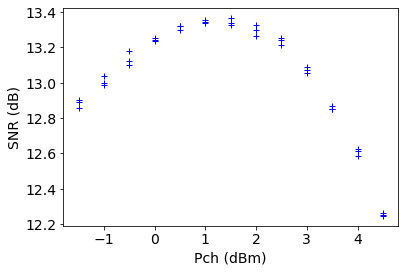

In [4]:
plt.plot(pch, snr, 'b+')
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.show()

In [61]:
print(min(pch))

-1.0


Data consists of time series measurements of SNR as a function of Pch - values are recorded in 0.5 dBm increments, with multiple recorded values of SNR at each Pch. 

We can define a GP model using the GPy library, a powerful open source Gaussian Process library.

In [70]:
snr = snr.reshape(len(snr),1)
pch = pch.reshape(len(pch),1)

In [72]:
kern_gpy = GPy.kern.RBF(1) + GPy.kern.White(1) 
m1 = GPy.models.GPRegression(pch,snr,kern_gpy)
start = time.time()
m1.optimize()
end = time.time()
print("GPy took " + str(end-start) + "s")
lml_sgp = m1.log_likelihood()
print("GPy LML = " + str(lml_sgp))

GPy took 0.06316375732421875s
GPy LML = 75.07804853891383


In [73]:
mu_gpy, var_gpy = m1.predict(pch)  # extract predictive mean and variance from GPy model 
std_gpy = var_gpy**0.5
mu_gpy_p = mu_gpy + std_gpy*2
mu_gpy_n = mu_gpy - std_gpy*2

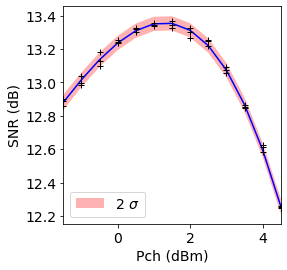

In [74]:
f, ax = plt.subplots()
ax.plot(pch, mu_gpy, color = 'b')
ax.plot(pch, snr,'k+')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_gpy_p,
                            (mu_gpy_n)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

**Approach**: have forked the scikit-learn library and cloned it to my local machine, then set it up so that I can edit the source code and run it in this working env. Pip list shows this library as being installed in this way: 1.0.dev0 /Users/joshnevin/sklearnforked/scikit-learn.
**Note**: in order to see the changes to the code, I need to restart the kernel and import the library again. Thus, I have included a quick setup cell below. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
#snr_phys = np.genfromtxt(open("snr_gn.csv", "r"), delimiter=",", dtype =float).reshape(-1,1) # calculated using GN model class

As a substitute for an accurate physical model, use polynomial fit. Need to fix my GN model code and obtain reasonable agreement...

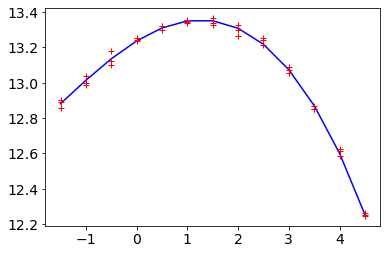

In [4]:
z = np.polyfit(pch, snr, 5)
p = np.poly1d(z)
snr_phys = p(pch).reshape(-1,1)
plt.plot(pch, snr_phys, '-b')
plt.plot(pch, snr, 'r+')
plt.show()

In [5]:
try:
    snr_phys.shape[1]
except:
    raise IndexError("need to reshape data using reshape(-1,1)")

In [12]:
pch = pch.reshape(-1, 1)  # needed for SK learn input
snr = snr.reshape(-1, 1)
kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr.fit_phys(pch, snr, snr_phys)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk, std_sk = gpr.predict(pch, return_std=True )
std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
theta = gpr.kernel_.theta
lml = gpr.log_marginal_likelihood()
mu_sk_p = mu_sk + 2*std_sk 
mu_sk_n = mu_sk - 2*std_sk 

In [10]:
%%timeit
gpr.fit_phys(pch, snr, snr_phys)

/Users/joshnevin/sklearnforked/scikit-learn/sklearn/gaussian_process/_gpr.py:740: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/joshnevin/sklearnforked/scikit-learn/sklearn/gaussian_process/_gpr.py:740: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


613 ms ± 43.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit
gpr.fit(pch, snr)

594 ms ± 70.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


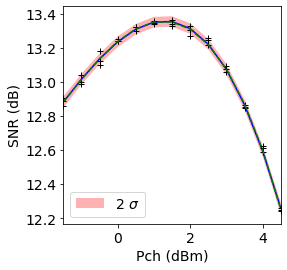

In [13]:
f, ax = plt.subplots()
ax.plot(pch, mu_sk, 'b-')
ax.plot(pch, snr,'k+')
ax.plot(pch, snr_phys, 'g--')
ax.fill(np.concatenate([pch, pch[::-1]]),
            np.concatenate([mu_sk_p,
                            (mu_sk_n)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch[0], pch[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

**Physical model** start with GN model: 10 100km spans, Pch is the same for each span. 

In [11]:
class GN_model:
    def __init__(self, span_len, lam_op, num_lam, nl_cof, disp_cof,  alpha, r_sym, bchrs, grid_sp, n_fig, num_spans):
        self.span_len = span_len
        self.lam_op = lam_op
        self.num_lam = num_lam
        self.nl_cof = nl_cof
        self.disp_cof = disp_cof
        self.alpha = alpha
        self.r_sym = r_sym
        self.bchrs = bchrs
        self.grid_sp = grid_sp
        self.n_fig = n_fig
        self.num_spans = num_spans
        self.freq = 299792458/(self.lam_op*1e-9)
        self.al_lin = np.log((10**(self.alpha/10)))/2 # fibre loss [1/km] 
        self.beta2 = (self.disp_cof*(self.lam_op**2))/(2*np.pi*299792.458) # dispersion coefficient at given wavelength [ps^2/km]
        self.l_eff = (1 - np.exp(-2*self.al_lin*self.span_len ))/(2*self.al_lin) # effective length [km]
        self.l_eff_as = 1/(2*self.al_lin) # the asymptotic effective length [km]  
        self.h = 6.63*1e-34 # Planck's constant [Js]
    
    def predict_snr(self, p_ch):
        Gwdm = (1e-3*10**(p_ch/10))/(self.bchrs*1e9)
        Gnli = 1e24*(8/27)*(self.nl_cof**2)*(Gwdm**3)*(self.l_eff**2)*((np.arcsinh((np.pi**2)*0.5*self.beta2*self.l_eff_as*(self.bchrs**2)*(self.num_lam**((2*self.bchrs)/self.grid_sp))  ) )/(np.pi*self.beta2*self.l_eff_as))*self.num_spans                                                                             
        Pase = self.n_fig*self.h*self.freq*(self.convert_to_lin(self.alpha*self.span_len) - 1)*self.bchrs*1e9*self.num_spans       
        Pch = 1e-3*10**(p_ch/10) 
        snr = (Pch/(Pase + Gnli*self.bchrs*1e9))
        #snr = ( snr**(-1) + (convert_to_lin(TRxb2b))**(-1) )**(-1)
        return self.convert_to_db(snr)
    
    def find_pch_opt(self):  # return optimal Pch in dBm
        PchdBm = np.linspace(-6,6,500)  # 500 datapoints for higher resolution of Pch
        numpch = len(PchdBm)
        Pchsw = 1e-3*10**(PchdBm/10)  # convert from dBm to linear units [W]
        Gwdmsw = Pchsw/(self.bchrs*1e9)
        Gnlisw = 1e24*(8/27)*(self.nl_cof**2)*(Gwdmsw**3)*(self.l_eff**2)*((np.arcsinh((np.pi**2)*0.5*self.beta2*self.l_eff_as*(self.bchrs**2)*(self.num_lam**((2*self.bchrs)/self.grid_sp))  ) )/(np.pi*self.beta2*self.l_eff_as))
        G = self.alpha*self.span_len
        NFl = 10**(self.n_fig/10) # convert to linear noise figure
        Gl = 10**(G/10) # convert to linear gain
        Pasesw = NFl*self.h*self.freq*(Gl - 1)*self.bchrs*1e9 # [W] the ASE noise power in one Nyquist channel across all spans
        snrsw = (Pchsw)/(Pasesw*np.ones(numpch) + Gnlisw*self.bchrs*1e9)
        return PchdBm[np.argmax(snrsw)] 
    
    def convert_to_lin(self, x):
        return 10**(x/10)
    
    def convert_to_db(self, x):
        return 10*np.log10(x)

         

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient, dispersion coefficient, loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans 

In [12]:
phys_model = GN_model(100, 1550, 1, 1.27, 16.7, 0.2, 32, 41.6, 50, 4.5, 10)

In [13]:
phys_model.find_pch_opt() 

-0.9018036072144291

In [14]:
snr_gn = phys_model.predict_snr(pch)
np.savetxt('snr_gn.csv', snr_gn, delimiter=',') 

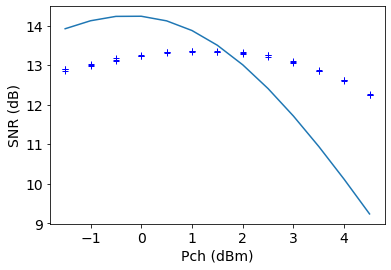

In [7]:
plt.plot(pch, snr, 'b+')
plt.plot(pch, snr_gn)
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.show()

SKlearn source code edits required: 
1. change GaussianProcessRegressor class constructor to also take physical model data as an input